In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow import keras

In [2]:
def plot_series(series, y=None, y_pred=None, title = None, x_label="$t$", y_label="$x(t)$"):
    n_steps = series.shape[0]
    plt.plot(series, ".-", label = 'Past Events')
    if y is not None:
        plt.plot(n_steps, y, "rx", markersize=8, label = 'Actual Future')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "go", label = 'Predicted Future')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    if title:
        plt.title(title)
    plt.legend()

def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path);

In [4]:
dataframe = pd.read_csv(csv_path)
print('The dataset has {} observations'.format(dataframe.shape[0]))
features = list(dataframe.columns)
features = ('\n'.join(features))
print('The dataset has the following features: \n{}'.format(features))

The dataset has 420551 observations
The dataset has the following features: 
Date Time
p (mbar)
T (degC)
Tpot (K)
Tdew (degC)
rh (%)
VPmax (mbar)
VPact (mbar)
VPdef (mbar)
sh (g/kg)
H2OC (mmol/mol)
rho (g/m**3)
wv (m/s)
max. wv (m/s)
wd (deg)


Every observation is recorded every 10 minutes, so one hour has 6 observations, and a whole day has 144 observations. 
As we saw above, there are 420551 observations, and therefore, we have observations for around 8 years

In [5]:
print('The dataset goes from {} to {}'.format(dataframe['Date Time'].iloc[0][0:10], dataframe['Date Time'].iloc[-1][0:10]))

The dataset goes from 01.01.2009 to 01.01.2017


Taking all the observations would be very memory consuming. Thus, we can use a time window of 2 years (105000 observations, let's round it up to 110000) to predict the weather in 6 hours (36 observations ahead).

Let's create a function that allows us to take as many observations as we want. We will use this function later, when we need to split the data into training, validation, and testing

In [6]:
def window(data, start_index, end_index, history_size, target_size):
    data_list = []
    labels_list = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(data) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data_list.append(np.reshape(data[indices], (history_size, 1)))
        labels_list.append(data[i+target_size])
        
    return np.array(data_list), np.array(labels_list)

In [7]:
temp = dataframe['T (degC)']
temp.index = dataframe['Date Time'] # Change the numerical index for its corresponding date

We can see that the values goes from -20C to around 35C. It is not a huge change of scale, but it would be a good idea to normalize the data to train our model.
Recall that we just normalize the training data, so it takes the mean and standard deviation of the training set rather than the whole dataset

In [8]:
temp_arr = temp.values # transform from series to numpy

In [9]:
n_train = 110000
temp_mean = temp_arr[:n_train].mean()
temp_std = temp_arr[:n_train].std()
temp_norm = (temp_arr-temp_mean)/temp_std

In [10]:
n_batch = 20 # Number of observations in each batch
n_future = 0 # How many steps ahead from the training data

x_train_temp, y_train_temp = window(temp_norm, 0, n_train, n_batch, n_future)
x_val_temp, y_val_temp     = window(temp_norm, n_train, None, n_batch, n_future)

![title](Time_series.png)

Before getting our hands dirty, it would be nice to have some baseline metrics, so after training the model, we have something to compare our model with.

There are many ways to do this comparison, such as the mean, or the naive forecasting (which assumes that the following data is the same as the last value)

![title](Metrics.png)

In [11]:
batch_train = 256
n_buffer = 10000

train_data = tf.data.Dataset.from_tensor_slices((x_train_temp, y_train_temp))
train_data = train_data.cache().shuffle(n_buffer).batch(batch_train).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val_temp, y_val_temp))
val_data = val_data.batch(batch_train).repeat()

## Mean Forecasting

Let's take the first time window, and compute its mean. 
The predicted value will be the result

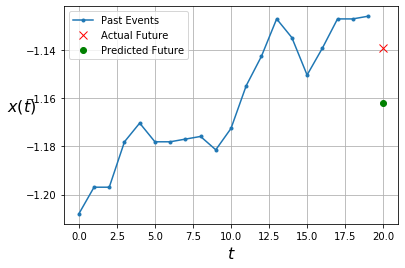

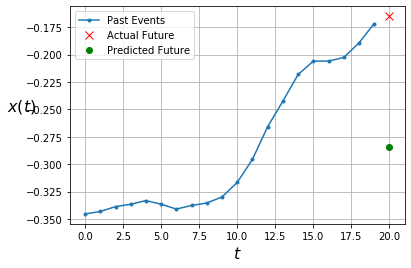

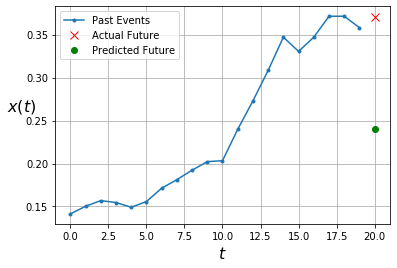

In [12]:
for x, y in val_data.take(3):
    plot_series(series = x[0], y=y[0].numpy(), y_pred=tf.math.reduce_mean(x[0]))
    plt.show()

The metric we can use is the MSE

## Naive Forecasting

Let's take the fifth window for sake of clarity.
The predicted value will be the same as the last value in the training set

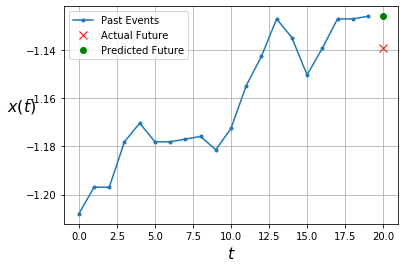

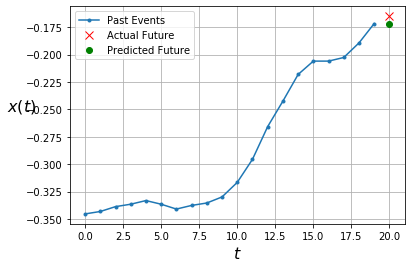

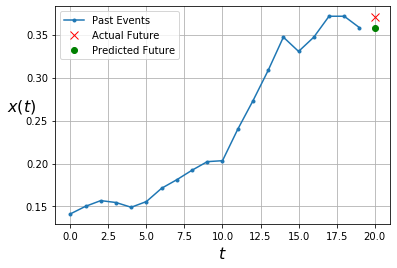

In [14]:
for x, y in val_data.take(3):
    plot_series(series = x[0], y=y[0].numpy(), y_pred=x[0,-1])
    plt.show()

We have our first baselines. Another easy baseline is using a linear neural network

## Linear Forecasting

In [15]:
np.random.seed(42) 
tf.random.set_seed(42)
keras.backend.clear_session

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=x_train_temp.shape[-2:]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam")
model.fit(train_data, epochs=20,  steps_per_epoch=200,
            validation_data=val_data, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 0s 2ms/step - loss: 0.5887 - val_loss: 0.0510
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0462
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0401
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0339
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.0223 - val_loss: 0.0281
Epoch 6/20
200/200 [==============================] - 0s 995us/step - loss: 0.0185 - val_loss: 0.0226
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.0144 - val_loss: 0.0182
Epoch 8/20
200/200 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0141
Epoch 9/20
200/200 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0113
Epoch 10/20
200/200 [==============================] - 

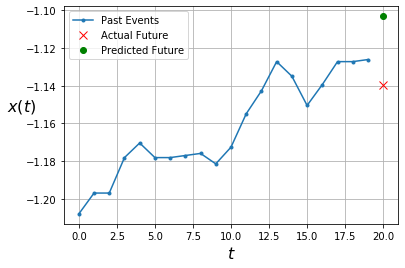

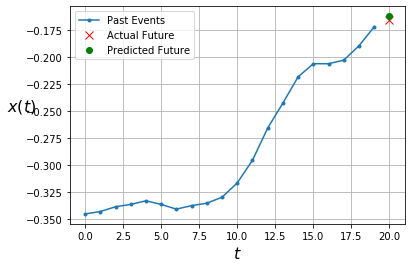

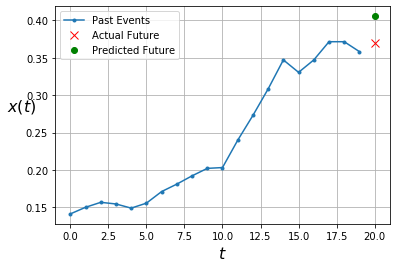

In [16]:
for x, y in val_data.take(3):
    plot_series(series = x[0], y=y[0].numpy(), y_pred=model.predict(x)[0])
    plt.show()